In [1]:
# A1_entropy.py - Calculate entropy of target column with optional binning

import pandas as pd
import numpy as np


df = pd.read_csv("embedded_dataset_deberta.csv")
target_col = df.columns[-1]


def entropy(y):
    counts = y.value_counts(normalize=True)
    return float(-np.sum([p * np.log2(p) for p in counts if p > 0]))

def equal_width_binning(series, bins=4):
    labels = [f"bin_{i}" for i in range(bins)]
    return pd.cut(series, bins=bins, labels=labels, include_lowest=True).astype(str)


y = df[target_col]
if pd.api.types.is_numeric_dtype(y):
    y = equal_width_binning(y, bins=4)

print(f"Entropy of {target_col}: {entropy(y)}")

Entropy of label: 1.8701269786219525


In [2]:
# A2_gini.py - Calculate Gini index of target column

import pandas as pd

df = pd.read_csv("embedded_dataset_deberta.csv")
target_col = df.columns[-1]

def gini_index(y):
    counts = y.value_counts(normalize=True)
    return float(1.0 - sum([p**2 for p in counts]))

def equal_width_binning(series, bins=4):
    labels = [f"bin_{i}" for i in range(bins)]
    return pd.cut(series, bins=bins, labels=labels, include_lowest=True).astype(str)

y = df[target_col]
if pd.api.types.is_numeric_dtype(y):
    y = equal_width_binning(y)

print(f"Gini index of {target_col}: {gini_index(y)}")


Gini index of label: 0.708486503636174


In [3]:
# A3_root_feature.py - Determine root node feature using Information Gain

import pandas as pd
import numpy as np

df = pd.read_csv("embedded_dataset_deberta.csv")
target_col = df.columns[-1]

def entropy(y):
    counts = y.value_counts(normalize=True)
    return float(-np.sum([p * np.log2(p) for p in counts if p > 0]))

def information_gain(parent_y, split_series):
    total_entropy = entropy(parent_y)
    df_tmp = pd.DataFrame({'y': parent_y, 'split': split_series})
    weighted_entropy = 0
    for _, g in df_tmp.groupby('split')['y']:
        weighted_entropy += (len(g) / len(df_tmp)) * entropy(g)
    return total_entropy - weighted_entropy

def equal_width_binning(series, bins=4):
    labels = [f"bin_{i}" for i in range(bins)]
    return pd.cut(series, bins=bins, labels=labels, include_lowest=True).astype(str)

y = df[target_col]
if pd.api.types.is_numeric_dtype(y):
    y = equal_width_binning(y)

best_feat, best_gain = None, -np.inf
for col in df.columns:
    if col == target_col:
        continue
    feature = df[col]
    if pd.api.types.is_numeric_dtype(feature):
        feature = equal_width_binning(feature)
    gain = information_gain(y, feature)
    if gain > best_gain:
        best_feat, best_gain = col, gain

print(f"Best root feature: {best_feat}, Information Gain: {best_gain}")

Best root feature: embedding_58, Information Gain: 0.24109426171288906


In [4]:
# A4_binning_demo.py - Show equal-width and equal-frequency binning for first numeric column

import pandas as pd

df = pd.read_csv("embedded_dataset_deberta.csv")
numeric_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
if not numeric_cols:
    raise ValueError("No numeric columns found for binning demo.")

col_name = numeric_cols[0]
series = df[col_name]

def equal_width_binning(series, bins=4):
    labels = [f"bin_{i}" for i in range(bins)]
    return pd.cut(series, bins=bins, labels=labels, include_lowest=True)

def equal_frequency_binning(series, bins=4):
    labels = [f"qbin_{i}" for i in range(bins)]
    return pd.qcut(series, q=bins, labels=labels, duplicates='drop')

print(f"Column: {col_name}")
print("\nEqual-width binning:")
print(equal_width_binning(series).value_counts())
print("\nEqual-frequency binning:")
print(equal_frequency_binning(series).value_counts())

Column: embedding_0

Equal-width binning:
embedding_0
bin_3    4096
bin_2     332
bin_0       2
bin_1       2
Name: count, dtype: int64

Equal-frequency binning:
embedding_0
qbin_0    1108
qbin_1    1108
qbin_2    1108
qbin_3    1108
Name: count, dtype: int64


In [5]:
# A5_build_tree.py - Build Decision Tree using sklearn

import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv("embedded_dataset_deberta.csv")
target_col = df.columns[-1]

def equal_width_binning(series, bins=4):
    labels = [f"bin_{i}" for i in range(bins)]
    return pd.cut(series, bins=bins, labels=labels, include_lowest=True).astype(str)

X = df.drop(columns=[target_col])
y = df[target_col]

for col in X.columns:
    if pd.api.types.is_numeric_dtype(X[col]):
        X[col] = equal_width_binning(X[col])

le_y = LabelEncoder()
y_enc = le_y.fit_transform(y.astype(str))

for col in X.columns:
    le_feat = LabelEncoder()
    X[col] = le_feat.fit_transform(X[col].astype(str))

clf = DecisionTreeClassifier(max_depth=5, random_state=42)
clf.fit(X, y_enc)
print("Decision Tree trained successfully.")


Decision Tree trained successfully.


In [6]:
# A6_visualize_tree.py - Final fix for numeric target issue

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder


df = pd.read_csv("embedded_dataset_deberta.csv")
target_col = df.columns[-1]

def equal_width_binning(series, bins=4):
    labels = [f"bin_{i}" for i in range(bins)]
    return pd.cut(series, bins=bins, labels=labels, include_lowest=True).astype(str)


X = df.drop(columns=[target_col])
y = df[target_col]


for col in X.columns:
    if pd.api.types.is_numeric_dtype(X[col]):
        X[col] = equal_width_binning(X[col])


le_y = LabelEncoder()
y_enc = le_y.fit_transform(y.astype(str))


for col in X.columns:
    le_feat = LabelEncoder()
    X[col] = le_feat.fit_transform(X[col].astype(str))


clf = DecisionTreeClassifier(max_depth=5, random_state=42)
clf.fit(X, y_enc)

feature_names_list = [str(f) for f in X.columns]
class_names_list = [str(c) for c in le_y.classes_]


plt.figure(figsize=(12,8))
plot_tree(
    clf,
    feature_names=feature_names_list,
    class_names=class_names_list,
    filled=True,
    rounded=True
)
plt.savefig("dtree.png", dpi=300)
plt.close()
print("Saved dtree.png successfully.")


Saved dtree.png successfully.


Saved decision_boundary.png


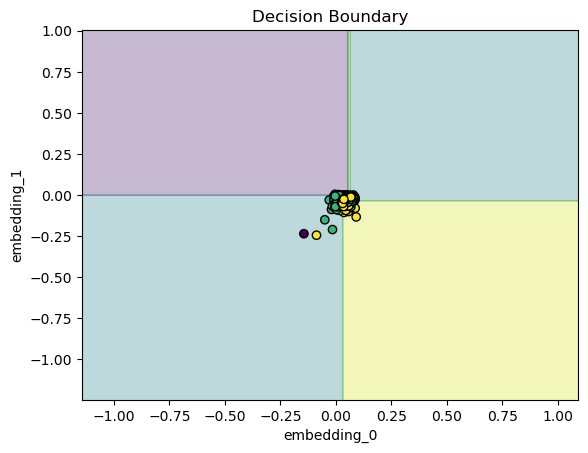

In [7]:
# A7_decision_boundary.py - Plot decision boundary using two numeric features

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv("embedded_dataset_deberta.csv")
target_col = df.columns[-1]

numeric_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c]) and c != target_col]
if len(numeric_cols) < 2:
    raise ValueError("Not enough numeric features for decision boundary.")

feat1, feat2 = numeric_cols[:2]
X = df[[feat1, feat2]].values

le_y = LabelEncoder()
y = le_y.fit_transform(df[target_col].astype(str))

clf = DecisionTreeClassifier(max_depth=5, random_state=42)
clf.fit(X, y)

x_min, x_max = X[:,0].min()-1, X[:,0].max()+1
y_min, y_max = X[:,1].min()-1, X[:,1].max()+1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X[:,0], X[:,1], c=y, edgecolor='k')
plt.xlabel(feat1)
plt.ylabel(feat2)
plt.title("Decision Boundary")
plt.savefig("decision_boundary.png")
print("Saved decision_boundary.png")